# Imports and definitions

In [1]:
from utils import *

### Base path ###
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
spot_name = 'P2giallo100s'
path_input = path_shared + 'dataXRDXRF/MuseoEgizio2022/SpotMeasurements/CalibFinale/'
path_spot = path_input + spot_name + '/'

file_xrd         = path_spot + 'Frame0001.dat'   # XRD scan
file_calibration = path_input + 'calibration.ini'
file_xrf = path_spot + spot_name + '.spe'    # XRF scan

path_database = path_shared + 'Database16_42/'     # tabulated phases

### Output ###
subfolder_output = 'CalibFinale/' + spot_name + '/'
path_figures = subfolder_output + 'figures/'            # figures generated by the script
path_database_exp = subfolder_output + 'databaseEXP/'   # experimental phases
path_calibrations = subfolder_output + 'calibrations/'  # calibrated XRD spectra
path_peaks = subfolder_output + 'peaks/'                # peaks automatically found in experimental XRD pattern

paths_to_create_delete = [path_figures, path_database_exp, path_calibrations, path_peaks]

### Fit ###
min_theta = 17
max_theta = 42
min_intensity = 0.05   # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None   # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.15           # sigma used in the peaks of synthetic diffraction patterns

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:', len(database))

Phases in database: 436


# Read and process XRD data

Loading '../../shared/dataXRDXRF/MuseoEgizio2022/SpotMeasurements/CalibFinale/P2giallo100s/Frame0001.dat'
Data length: 1280
Initial calibration:
a = -1233.1, s = 2770.7, beta = 41.190
Theta range [17.19831369 42.13925368]


/Users/dariozappala/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


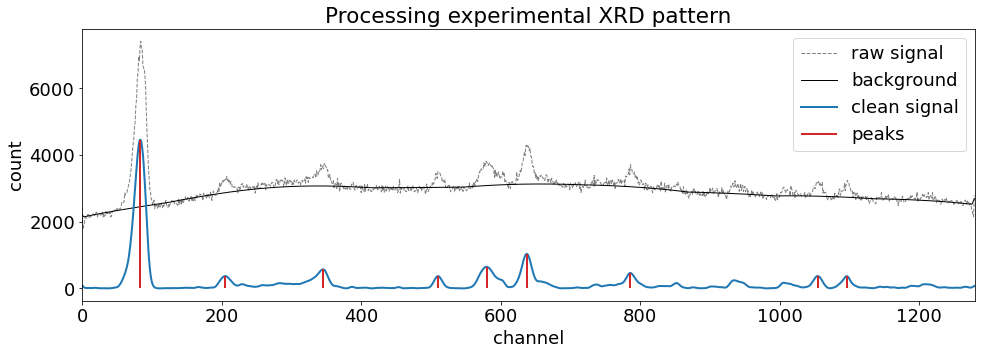

In [14]:
rcParams['font.size'] = 18

### Parameters for smoothing ###
window_snip = 32         # width of the window used for determining the background (default 32)
offset_background = 60   # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3           # degree of the final smooth applied to the XRD pattern (default 0)

### Parameters for searching peaks ###
width_peak = 10     # Minimum width of the peaks, in channels (default 10)
height_peak = 0.1   # Minimum height of the peaks, between 0 and 1, compared against a logarithmic function of the XRD pattern

###

print(f'Loading \'{file_xrd}\'')
spectrum_xrd = FastSpectraXRD().from_file(file_xrd)
spectrum_xrd.calibrate_from_file(file_calibration)
spectrum_xrd.background_elimination_and_smoothing(window_snip = window_snip, offset_background = offset_background, std_smooth = std_smooth, avoid_negative = True)
print(f'Data length: {spectrum_xrd.counts.shape[0]}')
print('Initial calibration:')
print(f'a = {spectrum_xrd.opt[0]:.1f}, s = {spectrum_xrd.opt[1]:.1f}, beta = {spectrum_xrd.opt[2]:.3f}')
print(f'Theta range {spectrum_xrd.theta_range()}')

signal_for_peaks = log(spectrum_xrd.intensity + 1)
signal_for_peaks /= signal_for_peaks.max()
peaks_position = find_peaks(signal_for_peaks, width = width_peak, height = height_peak)[0]
peaks_intensity = spectrum_xrd.intensity[peaks_position]
arr_to_write = concatenate(
    (spectrum_xrd.fce_calibration(peaks_position, *spectrum_xrd.opt)[:, newaxis],
     peaks_intensity[:, newaxis]),
    axis = 1
)
savetxt(f'{path_peaks}xrd peaks with initial calibration.dat', arr_to_write, '%.3f %.3f')

fig, ax = subplots(figsize = (16, 5))
ax.plot(spectrum_xrd.counts, c = 'grey', ls = '--', lw = 1, label = 'raw signal')
ax.plot(spectrum_xrd.background_shifted, c = 'black', ls = '-', lw = 1, label = 'background')
ax.plot(spectrum_xrd.counts_smoothed, lw = 2, label = 'clean signal')
ax.vlines(peaks_position, 0, spectrum_xrd.counts_smoothed[peaks_position], color = 'tab:red', lw = 2, label = 'peaks')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(0, len(spectrum_xrd.counts))
ax.set_xlabel('channel')
ax.set_ylabel('count')
ax.set_title('Processing experimental XRD pattern')
show()

# Read XRF spectrum

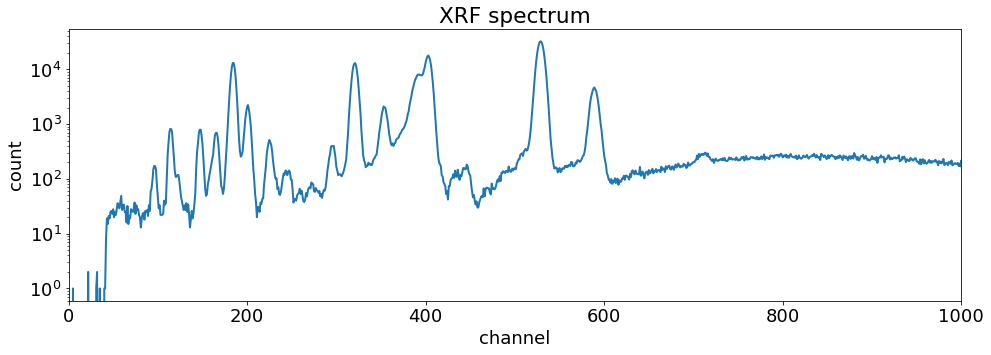

In [15]:
#limits_channel = [0, None]   # default limits
limits_channel = [0, 1000]   # custom limits

log_y_scale = True

spectrum_xrf = SpectraXRF().from_spe(file_xrf)
fig, ax = subplots(figsize = (16, 5))
ax.plot(spectrum_xrf.counts, lw = 2, label = 'raw signal')
if log_y_scale:
    ax.set_yscale('log')
ax.set_xlim(*limits_channel)
ax.set_xlabel('channel')
ax.set_ylabel('count')
ax.set_title('XRF spectrum')
show()

# Obtain list of phases

### Search phases with given elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [16]:
elements_chosen = ['Na']
elements_excluded = ['Pb', 'Co', 'Ni', 'Cd', 'Li']
# DO NOT EXCLUDE: Al, Ca, Cl, P, S, Si

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,Cyanide Sodalite,C2 Al6 N2 Na16 O24 Si6,1
1,Lazurite,Al2.97 Ca0.8 Mg0.36 Na3.12 O15.12 S Si3.03,4
2,MadderLake_LapisLazuli,Na Ca Al Si O S Cl,1
3,MadderLake_LapisLazuli_2,Na Ca Al Si O S Cl,1
4,MadderLake_LapisLazuli_3,Na Ca Al Si O S Cl,1
5,Sodalite,Al6 Cl2 Na8 O24 Si6,23
6,Thenardite,Na2 O4 S,1
7,V sodium calcium aluminium silicate,Na Ca Al Si O S Cl,6
8,V sodium calcium aluminium silicate Copper Hyd...,Na Ca Al Si O S Cl Cu H,2


### Fit selected phases on experimental XRD pattern

In [17]:
list_overlap = []
list_overlap_avg = []
list_overlap_max = []
list_x_y = []

for i in range(df_phases.shape[0]):
    phase_name = df_phases['Name in database'].iloc[i]
    phase_set = database[phase_name]
    
    gs = GammaSearch([p for p in phase_set], spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gs = gs.fit_cycle(gamma = True, steps = 10)
    overlap = gs.overlap_area_ratio()
    list_overlap.append(overlap)

df_phases['Best overlap'] = [nanmax(list_overlap[i]) for i in range(df_phases.shape[0])]
df_phases.style.format({'Best overlap': '{:.3f}'})

,Name in database,Chemical formula,N. of samples,Best overlap
0,Cyanide Sodalite,C2 Al6 N2 Na16 O24 Si6,1,0.048
1,Lazurite,Al2.97 Ca0.8 Mg0.36 Na3.12 O15.12 S Si3.03,4,0.078
2,MadderLake_LapisLazuli,Na Ca Al Si O S Cl,1,0.230
3,MadderLake_LapisLazuli_2,Na Ca Al Si O S Cl,1,0.215
4,MadderLake_LapisLazuli_3,Na Ca Al Si O S Cl,1,0.475
5,Sodalite,Al6 Cl2 Na8 O24 Si6,23,0.196
6,Thenardite,Na2 O4 S,1,0.277
7,V sodium calcium aluminium silicate,Na Ca Al Si O S Cl,6,0.227
8,V sodium calcium aluminium silicate Copper Hydroxide Carbonate,Na Ca Al Si O S Cl Cu H,2,0.502


### Select phase samples
If the overlap of a phase is above `threshold_overlap`, the phase is selected.

In [18]:
threshold_overlap = 0.3

list_sel_name = []
list_sel_formula = []
list_sel_sample = []
list_sel_overlap = []

for i in range(df_phases.shape[0]):
    idx = (list_overlap[i] >= threshold_overlap)
    if any(idx):
        arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
        arr_overlap_filtered = list_overlap[i][idx]
        j = nanargmax(arr_overlap_filtered)
        
        list_sel_name.append(df_phases.loc[i, 'Name in database'])
        list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
        list_sel_sample.append(arr_sample_filtered[j])
        list_sel_overlap.append(arr_overlap_filtered[j])

df_phases_sel = DataFrame({
    'Phase': list_sel_name,
    'Formula': list_sel_formula,
    'Sample': list_sel_sample,
    'Overlap': list_sel_overlap,
})
df_phases_sel = df_phases_sel.sort_values(by = 'Phase').reset_index(drop = True)
df_phases_sel.style.format({'Overlap': '{:.3f}'})

,Phase,Formula,Sample,Overlap
0,MadderLake_LapisLazuli_3,Na Ca Al Si O S Cl,0,0.475
1,V sodium calcium aluminium silicate Copper Hydroxide Carbonate,Na Ca Al Si O S Cl Cu H,1,0.502


### Write file with list of selected phases

This cell writes the list of names of selected phases into the file `phases_selection.dat`. If the file does not exist, the cell creates it.

In [19]:
filename = f'{subfolder_output}phases_selection.dat'
df_phases_sel.to_csv(filename, header = False, index = False, mode = 'a', float_format = '%.3f')

### Delete file with list of selected phases
Delete the files `phases_selection.dat`.

In [20]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    filename = f'{subfolder_output}phases_selection.dat'
    if exists(filename):
        remove(filename)

# List of phases vs experimental XRD pattern

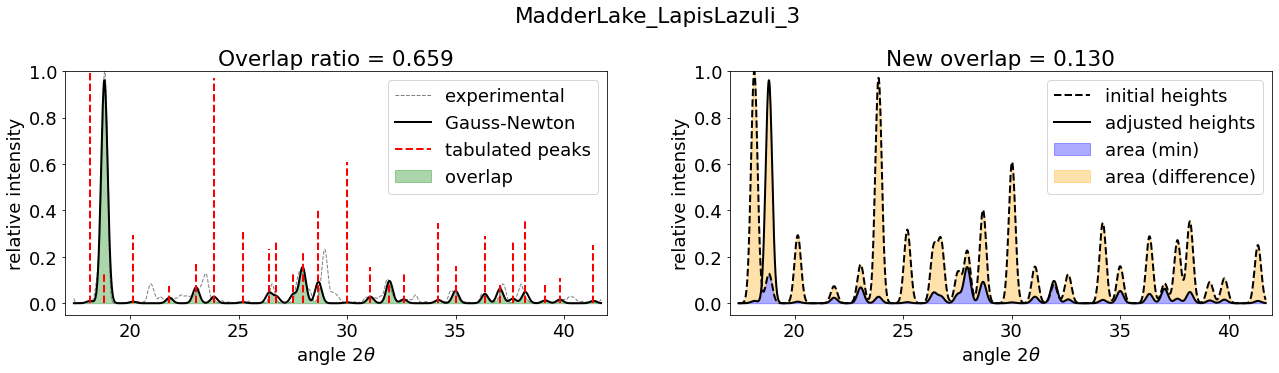

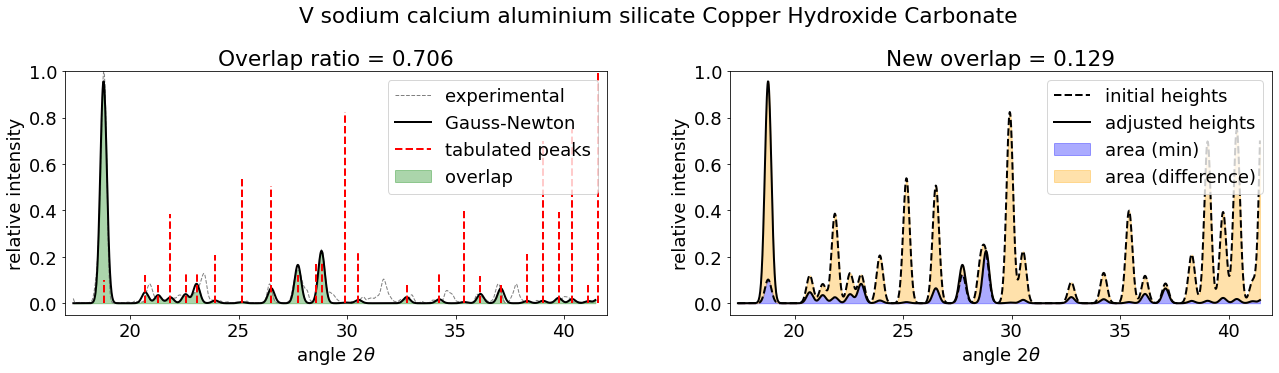

In [21]:
rcParams['font.size'] = 18

### Fit parameters ###
min_theta = 17
max_theta = 42
min_intensity = 0.05   # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None   # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.15           # sigma used in the peaks of synthetic diffraction patterns

### Calibration parameters ###
# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted depending on the value of 'phase_calibration'.
# If phase_calibration is set to a specific phase, the calibration with that phase will be used for the exploration of all the phases.
# If phase_calibration is set to None, each phase is calibrated on experimental XRD pattern.
adjust_calibration = True
#phase_calibration = database['Lazurite'][0]
phase_calibration = None

###

for i in range(df_phases_sel.shape[0]):
    
    ### Fit ###
    
    phase_name = df_phases_sel.loc[i, 'Phase']
    phase_sample = df_phases_sel.loc[i, 'Sample']
    phase_check = database[phase_name][phase_sample]

    gn = GaussNewton(phase_check, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    
    if adjust_calibration:
        if phase_calibration is None:
            p = phase_check
        else:
            p = phase_calibration
        gn_calibration = GaussNewton(p, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
        gn_calibration.fit_cycle(gamma = True, steps = 32).fit_cycle(a = True, s = True, gamma = True, steps = 16)
        gn.opt = gn_calibration.opt.copy()
        
        arr_to_write = concatenate((gn.theta[:, newaxis], gn.spectrum.counts[:, newaxis]), axis = 1)
        savetxt(f'{path_calibrations}xrd raw calibrated with {clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %d')
        arr_to_write = concatenate((gn.theta[:, newaxis], gn.spectrum.counts_smoothed[:, newaxis]), axis = 1)
        savetxt(f'{path_calibrations}xrd smoothed calibrated with {clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %.3f')
        
        arr_to_write = concatenate(
            (gn.fce_calibration(peaks_position, *gn.opt)[:, newaxis],
             peaks_intensity[:, newaxis]),
            axis = 1
        )
        savetxt(f'{path_peaks}xrd peaks calibrated with {clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %.3f')
    
    gn.fit_cycle(gamma = True, steps = 32)
    
    phase_exp = gn.make_phase()
    phase_exp.save_cif(path_database_exp + clean_phase_name(gn.label) + '.cif')

    z_min = minimum(gn.z(), gn.z0())
    z_max = maximum(gn.z(), gn.z0())
    overlap = z_min.sum() / z_max.sum()

    ### Plot ###

    fig, axs = subplots(1, 2, figsize = (18, 5))
    fig.tight_layout(w_pad = 4)
    fig.subplots_adjust(top = 0.8)   # To shift the title
    
    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.phase.plot(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity,
        first_n_peaks = first_n_peaks, lw = 2, alpha = 1, label = 'tabulated peaks')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')
    
    ax = axs[1]
    sca(ax)
    ax.plot(gn.theta, gn.z0(), c = 'black', ls = '--', lw = 2, label = 'initial heights')
    ax.plot(gn.theta, gn.z(), c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (difference)')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'New overlap = {overlap:.3f}')
    
    fig.suptitle(phase_name)
    
    savefig(f'{path_figures}{clean_phase_name(phase_name)} - check fit.png', bbox_inches = 'tight', dpi = 300)
    show()
    close(fig)

# Phase search and match

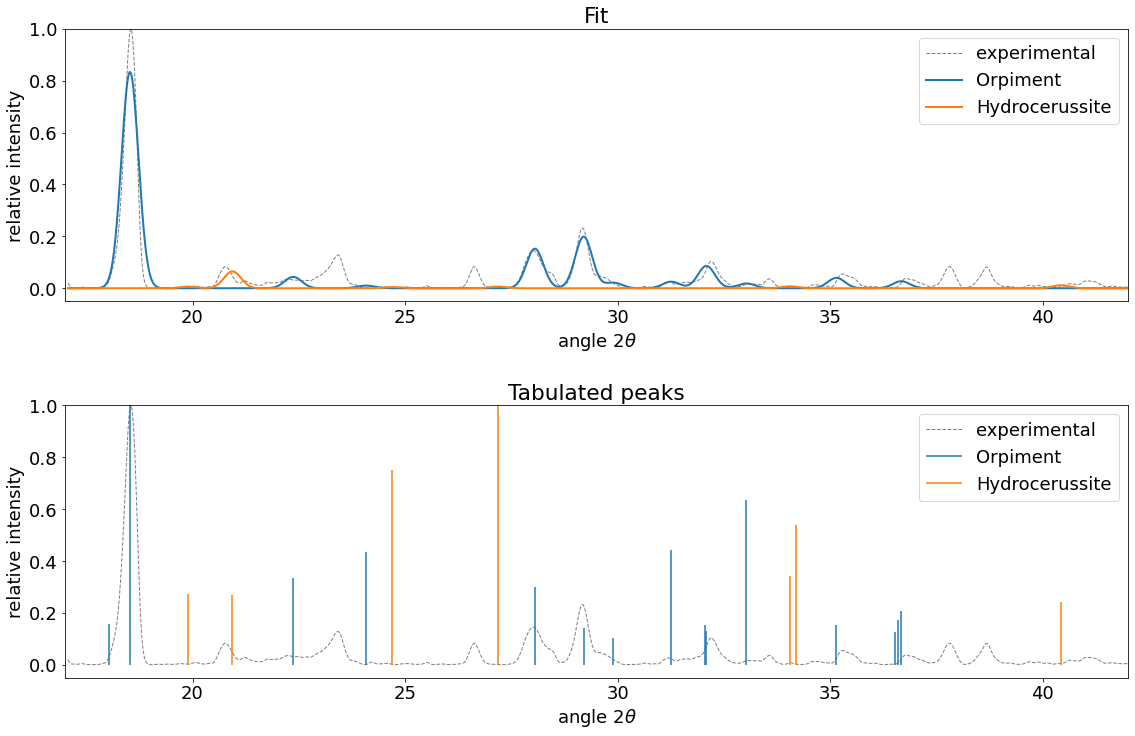

In [22]:
### Fit parameters ###
min_theta = 17
max_theta = 42
min_intensity = 0.1    # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None   # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.20           # sigma used in the peaks of synthetic diffraction patterns


### Calibration parameters ###
# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted by fitting phase_calibration on the experimental XRD pattern.
adjust_calibration = True
phase_calibration = database['Orpiment'][0]


### Visualization parameters ###
rcParams['font.size'] = 18

# List of phases that will be checked against the experimental XRD pattern
list_phases_check = [
    database['Orpiment'][0], database['Hydrocerussite'][0]
]

# The diffraction lines of this phase will be shown for comparison. Set to empty list in order to have no comparison.
#list_phases_comparison = [database['Wollastonite-2M'][0]]
list_phases_comparison = []


###

gs = GammaSearch(list_phases_check, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gn_calibration.fit_cycle(gamma = True, steps = 32).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gs.set_opt(gn_calibration.opt.copy())

gs.fit_cycle(gamma = True, steps = 32)


### Plot ###

fig, axs = subplots(2, 1, figsize = (16, 10))
fig.tight_layout(h_pad = 4)
cmap_sel = cm.get_cmap('tab10')

ax = axs[0]
sca(ax)
gs[0].plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
for i, gn in enumerate(gs):
    idx_color = i % cmap_sel.N
    ax.plot(gn.theta, gn.z(), lw = 2, color = cmap_sel(idx_color), label = shorten_string(gn.label, 30))
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title('Fit')

ax = axs[1]
sca(ax)
gs[0].plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
for i, phase in enumerate([gn.phase for gn in gs] + list_phases_comparison):
    idx_color = i % cmap_sel.N
    phase.plot(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity,
        first_n_peaks = first_n_peaks, colors = cmap_sel(idx_color), linestyles = '-', label = shorten_string(phase.label, 30))
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title('Tabulated peaks')

savefig(f'{path_figures}phases search match.png', bbox_inches = 'tight', dpi = 300)
show()

### Save experimental phases

In [23]:
# List of names of the experimental phases that will be saved
# These names will be chosen among list_phases_check
list_names_phase = ['Orpiment']

for gn in gs:
    if gn.label in list_names_phase:
        phase_exp = gn.make_phase()
        filename = path_database_exp + clean_phase_name(gn.label) + '.cif'
        print(filename)
        phase_exp.save_cif(filename)

CalibFinale/P2giallo100s/databaseEXP/Orpiment.cif
